# Initial Setup

In [1]:
# Imports
import os
from tqdm import tqdm
import torch
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import SGD
from torch.nn import Sequential

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report
import warnings
import logging
import random



In [2]:
# Reading the Dataset
columns = [
    "id","diagnosis","radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean",
    "concavity_mean","concave points_mean","symmetry_mean","fractal_dimension_mean","radius_se","texture_se","perimeter_se",
    "area_se","smoothness_se","compactness_se","concavity_se","concave points_se","symmetry_se","fractal_dimension_se","radius_worst",
    "texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst","concavity_worst","concave points_worst","symmetry_worst",
    "fractal_dimension_worst", "Unnamed: 32"
]
len(columns)
df   = pd.read_csv('dataset/wdbc.data', names = columns)

In [3]:
# For Plotting the HeatMap
def plot_correlation_heatmap(data):
    correlation = data.corr()  # Calculate the correlation matrix of the data
    
    # Set the size of the figure for the heatmap
    plt.figure(figsize=(18, 12))
    
    # Create the heatmap with correlation values and annotations
    sns.heatmap(correlation, annot=True)
    
    # Set the title of the heatmap
    plt.title('Correlation Heatmap')
    
    # Display the heatmap
    
    plt.show()

In [4]:
def seed_everything(seed):
    """
    Set random seed for reproducibility across different libraries and frameworks.

    Args:
        seed (int): Seed value to set for random number generators.
    """
    # Set random seed for Python's built-in random module
    random.seed(seed)

    # Set random seed for os.environ to control hashing of environment variable
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Set random seed for numpy
    np.random.seed(seed)

    # Set random seed for PyTorch on CPU
    torch.manual_seed(seed)

    # Set random seed for PyTorch on GPU (if available)
    torch.cuda.manual_seed(seed)

    # Enable deterministic behavior of cudnn (CUDA backend for PyTorch)
    torch.backends.cudnn.deterministic = True

    # Enable benchmark mode in cudnn for improved performance
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# EDA

In [5]:
# The first and foremost thing is to have a basic check of the Columns and DataTypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [6]:
# Then Next thing is to understadn the Column value ranges it is good to understand values from different columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


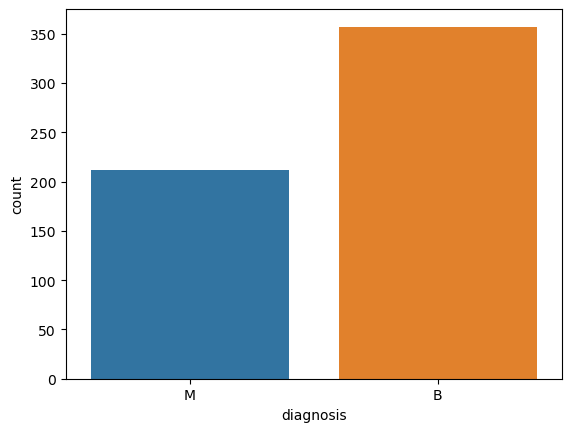

In [10]:
ax = sns.countplot(x="diagnosis", data=df)

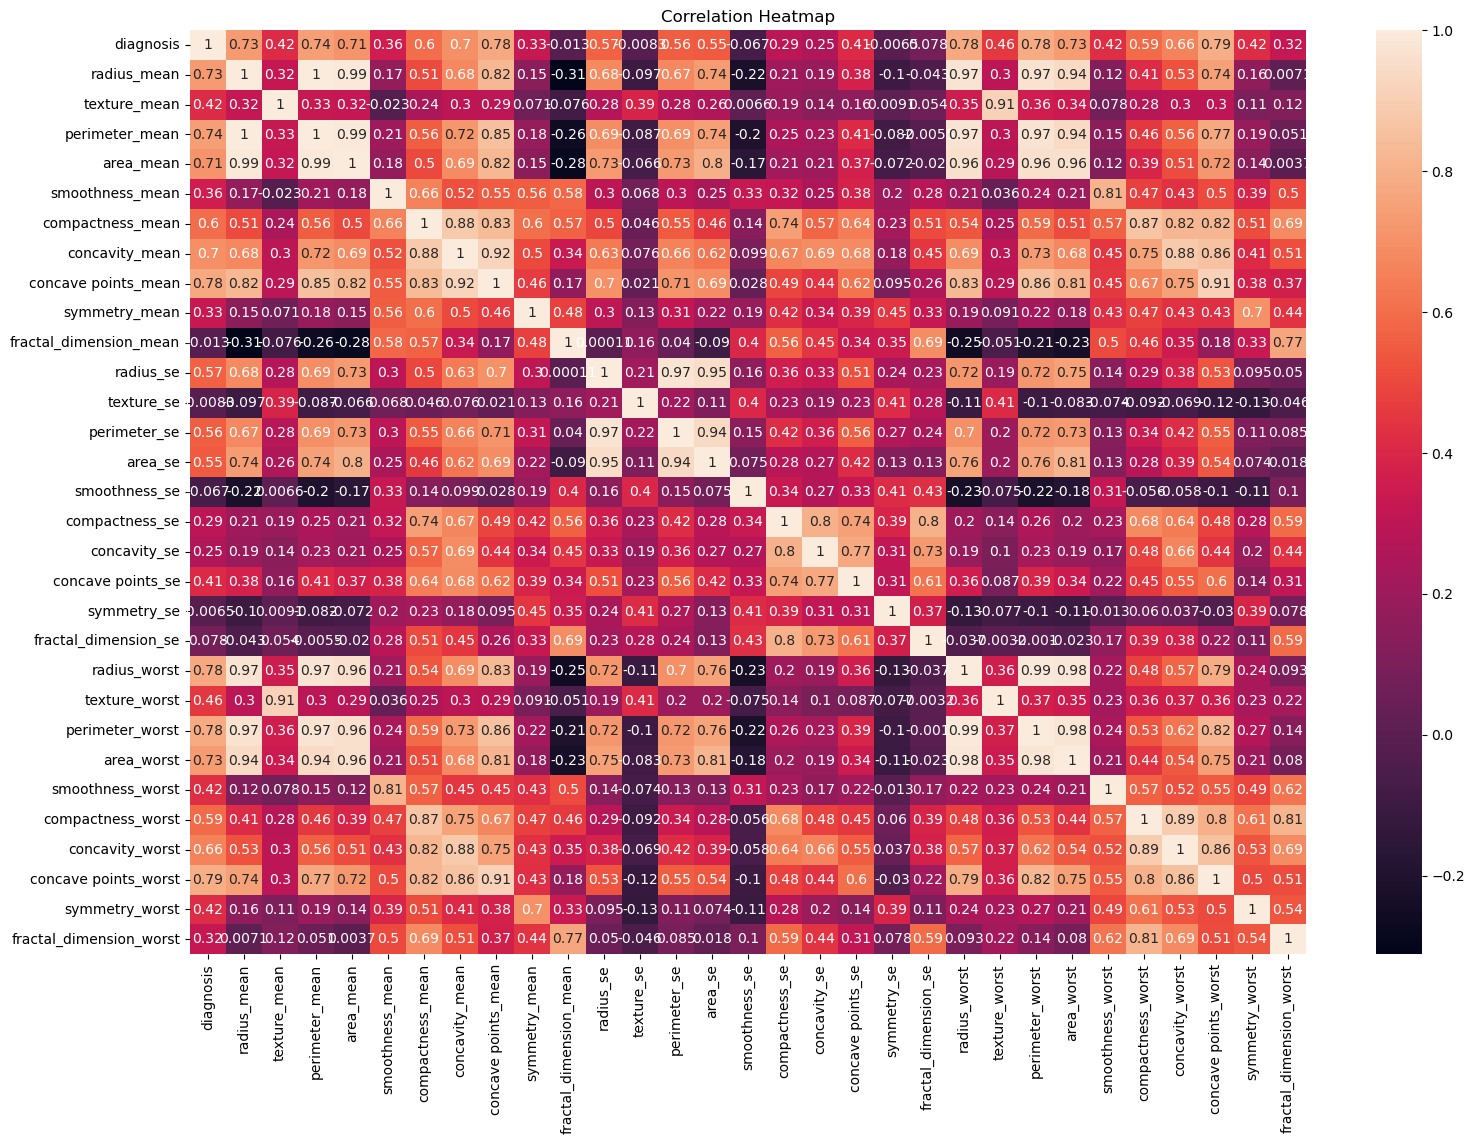

In [12]:
# Understanding the Correlation between the columns
plot_correlation_heatmap(df)

# Preprocessing

In [7]:
# Remove the 'id' and 'Unnamed: 32' columns from the 'data' DataFrame
df.drop(['id', 'Unnamed: 32'], axis=1,inplace=True)

In [8]:
# Check if there are any null values
df.isna().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [11]:
# Replacing the values of Label Column to 0 and 1
df['diagnosis'].replace({'B':0,'M':1},inplace=True)

# Hyper Parameters

In [13]:
# The device to run the model on.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# The number of epochs to train the model for.
epochs = 30

# The batch size to use during training.
batch_size = 32

# The learning rate for the optimizer.
learning_rate = 0.01

# The momentum for the optimizer.
momentum = 0.9

# The number of input features.
n_inputs = 30


# Dataset Prepration

In [14]:
# Split the dataset into features and target.
X = df.iloc[:,1:]
y = df.diagnosis
# Solitting the Dataset in to Train .7, Test .15, Val .15
X_train,X_test,y_train,y_test = train_test_split(X.values,y.values,test_size=0.3,stratify=y)
X_val,X_test,y_val,y_test =  train_test_split(X_test,y_test,test_size=0.5,stratify=y_test) 

In [15]:
# Using Standard Scaler to Normalize the Dataset
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [16]:
# Creating Dataset CLass to enable pytorch Data loading
class BreastCancerDataset(Dataset):
    def __init__(self, X,y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X) 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [26]:
# Creating DataLoaders
train_dataset = BreastCancerDataset(X_train,y_train)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = BreastCancerDataset(X_val,y_val)
val_dl = DataLoader(val_dataset, batch_size=X_val.shape[0], shuffle=False)

test_dataset = BreastCancerDataset(X_test,y_test)
test_dl = DataLoader(test_dataset, batch_size=X_test.shape[0], shuffle=False)

# Model Architecture

In [27]:
# Creating a very basic Neural Network
class ANN(nn.Module):
    def __init__(self,n_inputs):
        super(ANN, self).__init__()
        self.layers = Sequential(
            nn.Linear(n_inputs, 256),
            nn.ReLU(),
            nn.Dropout(.40),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(.40),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(.40),
            nn.Linear(16,1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.layers(x)

# Instantiating Model, Optimizer and Criterion
model = ANN(n_inputs)
model.to(device)
criterion = nn.BCELoss()
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [28]:
# Trying Early stopping to stop trainig if overfitting
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

# Training Function 
def train(loader, model, criterion, optimizer):
    model.train()
    train_loss_batch = []
    for i, (inputs, targets) in enumerate(loader): # enumerate mini batches
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() 
        preds = model(inputs.float())
        loss = criterion(preds, targets.unsqueeze(1).float()) 
        train_loss_batch.append(loss.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
    return sum(train_loss_batch)/len(train_dl)

# Validation Function
def val(loader, model, criterion):
    model.eval()
    val_loss_batch = []
    with torch.no_grad():
        for (inputs, targets) in loader:
            inputs, targets = inputs.to(device), targets.to(device) 
            preds = model(inputs.float())
            vloss = criterion(preds, targets.unsqueeze(1).float())
            val_loss_batch.append(vloss.cpu().detach().numpy())
            actual = targets.cpu().numpy()
            actual = actual.reshape((len(actual), 1))
            preds = preds.cpu().detach().numpy()
            preds = preds.round()
            val_accuracy.append(accuracy_score(actual, preds))
    return sum(val_loss_batch)/len(val_dl)

# Test Function
def test(loader, model, report = False):
    predictions, actuals = [], []
    model.eval()
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs,targets = inputs.to(device),targets.to(device)
            yhat = model(inputs.float()) 
            # retrieve numpy array
            yhat = yhat.cpu().detach().numpy()
            actual = targets.cpu().numpy()
            actual = actual.reshape((len(actual), 1))
            # round to class values
            yhat = yhat.round()
            # store
            predictions.append(yhat)
            actuals.append(actual)
        predictions, actuals = np.vstack(predictions), np.vstack(actuals)
            # calculate accuracy
        acc = accuracy_score(actuals, predictions)
        if report == True:
            print(classification_report(predictions,y_test))
        return acc

# Training Loop

In [29]:
train_loss   = []
val_loss     = []

early_stopper = EarlyStopping(tolerance=1, min_delta=10)

# Training Loop
for epoch in tqdm(range(epochs)):

    train_epoch_loss = train(train_dl, model, criterion, optimizer)
    val_epoch_loss = val(val_dl, model, criterion)
    
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    
    if early_stopper(train_epoch_loss, val_epoch_loss):
        break

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.84it/s]


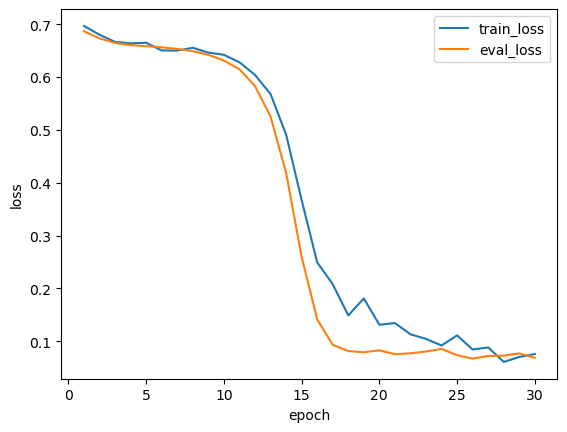

In [30]:
# Ploting Train loss vs Val Loss
x = list(range(1,epochs+1))
plt.figure()
plt.plot(np.array(x),np.array(train_loss),label='train_loss')
plt.plot(np.array(x),np.array(val_loss),label='eval_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [31]:
print("Training Accuracy :: ",test(train_dl, model))
print("Val.     Accuracy :: ",test(val_dl, model))
print("Test.    Accuracy :: ",test(test_dl, model))


Training Accuracy ::  0.992462311557789
Val.     Accuracy ::  0.9764705882352941
Test.    Accuracy ::  0.9651162790697675


In [32]:
test(test_dl, model, report = True)

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        57
         1.0       0.91      1.00      0.95        29

    accuracy                           0.97        86
   macro avg       0.95      0.97      0.96        86
weighted avg       0.97      0.97      0.97        86



0.9651162790697675